In [4]:
import sys, os
sys.path.append(os.path.abspath('../'))  # permet d’accéder au dossier parent
from src.utils.imports import *

 Toutes les librairies principales importées avec succès (Data | ML | MLOps | API | Orchestration).


In [7]:
df = pd.read_csv(r"C:\Users\kadas\Desktop\Fraude\fraudflow\data\creditcard.csv")

In [24]:
df=df[["V14","V4","V11","V12","V10","V16","V3","V17","V9","V2","Class", "Amount","Time"]]

In [25]:
# Features et cible
X = df.drop(columns=["Class", "Amount"])
y = df["Class"]

In [27]:
#  Séparation Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=90
)

In [28]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [ ]:
# 3. Entraînement du modèle
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=90
)

rf.fit(X_train_rf, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


| Objectif                                     | Paramètre                           | Ce qu’il fait                                                      | Recommandation               |
| -------------------------------------------- | ----------------------------------- | ------------------------------------------------------------------ | ---------------------------- |
| 🔧 **Limiter la profondeur**                 | `max_depth`                         | stoppe la croissance des arbres trop complexes                     | `10 ≤ max_depth ≤ 20`        |
| 🍃 **Éviter feuilles trop petites**          | `min_samples_leaf`                  | chaque feuille contient au moins X échantillons                    | `2 ≤ min_samples_leaf ≤ 5`   |
| 🌿 **Limiter les splits trop fins**          | `min_samples_split`                 | un nœud doit contenir au moins X échantillons avant d’être splitté | `3 ≤ min_samples_split ≤ 10` |
| 🎲 **Réduire la corrélation entre arbres**   | `max_features`                      | limite le nb de variables testées à chaque split                   | `"sqrt"` ou `"log2"`         |
| 🌪️ **Utiliser l’échantillonnage bootstrap** | `bootstrap=True`                    | chaque arbre voit un sous-échantillon des données                  | toujours `True` (par défaut) |
| ⚖️ **Équilibrer les classes**                | `class_weight='balanced_subsample'` | pondère selon le déséquilibre                                      | déjà fait 👍                 |
| 🌳 **Réduire le nb d’arbres**                | `n_estimators`                      | moins d’arbres → moins de variance (mais plus de biais)            | entre 200 et 400 suffisent   |


le RandomForestClassifier n’a pas de early_stopping car c’est un ensemble d’arbres indépendants (chaque arbre est entraîné jusqu’à sa fin, sans itérations successives).

In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='average_precision')
print(f"AUPRC CV moyen : {scores.mean():.4f} ± {scores.std():.4f}")

AUPRC CV moyen : 0.8363 ± 0.0293


En validation croisée 5 folds, j’obtiens un AUPRC moyen de 0.839 avec un écart-type de 0.03, ce qui montre que le modèle est stable et généralise bien sur différentes partitions.

In [35]:
# 4️. Prédictions et probabilités
y_pred_rf = rf.predict(X_test_rf)
y_proba_rf = rf.predict_proba(X_test_rf)[:, 1]


In [36]:
# 5️. Évaluation - AUPRC + Rapport
auprc_rf = average_precision_score(y_test, y_proba_rf)
print(f"\n AUPRC (Precision-Recall) : {auprc_rf:.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_rf, digits=4))



 AUPRC (Precision-Recall) : 0.8049

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56864
           1     0.9136    0.7551    0.8268        98

    accuracy                         0.9995     56962
   macro avg     0.9566    0.8775    0.9133     56962
weighted avg     0.9994    0.9995    0.9994     56962



Le modèle détecte environ 75 % des fraudes (recall),
et 91 % des alertes sont correctes (precision).
Le F1-score de 0.83 montre un bon équilibre entre détection et fiabilité.

En pratique, sur 100 vraies fraudes, le modèle en trouve 75,
et parmi les 100 alertes générées, 91 sont réellement des fraudes.


Le modèle ne pénalise quasiment pas les clients légitimes.( 0.9996 )
Les faux positifs restent très rares.

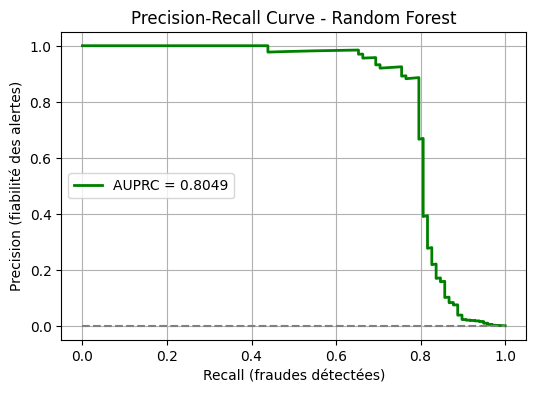

In [37]:
# 6️. Courbe Precision-Recall

precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2, label=f"AUPRC = {auprc_rf:.4f}")
plt.plot([0, 1], [np.mean(y_test)]*2, linestyle='--', color='gray')
plt.title("Precision-Recall Curve - Random Forest")
plt.xlabel("Recall (fraudes détectées)")
plt.ylabel("Precision (fiabilité des alertes)")
plt.legend()
plt.grid(True)
plt.show()

Il détecte bien les fraudes évidentes (60%) sans erreur, mais demande un effort humain pour vérifier les cas douteux (40% restants).

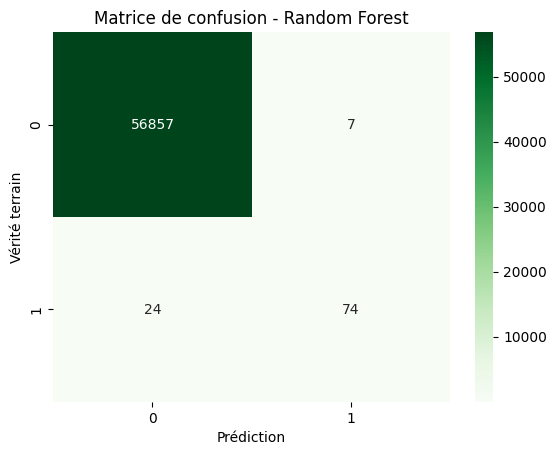


AUPRC Train: 0.9869 | AUPRC Test: 0.8049


In [38]:
# 7️. Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# 8️. AUPRC Train vs Test (pour vérifier sur-apprentissage)
# ==========================================================
y_train_proba_rf = rf.predict_proba(X_train_rf)[:, 1]
auprc_train_rf = average_precision_score(y_train, y_train_proba_rf)

print(f"\nAUPRC Train: {auprc_train_rf:.4f} | AUPRC Test: {auprc_rf:.4f}")